# Autoencoders

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cv2
import numpy as np
import os

from skimage.util import random_noise
from keras.models import Model
from keras.layers import Input, Dense
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from keras.layers import Conv2D, Conv2DTranspose, Flatten, MaxPooling2D, UpSampling2D, Reshape

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.tensorboard import SummaryWriter



In [71]:

def apply_salt_and_pepper(image, salt_ratio, pepper_ratio):
    """
    Aplica el filtro "Salt and Pepper" a una imagen.
    
    Args:
        image: Imagen de entrada.
        salt_ratio: porcentaje de puntos blancos
        pepper_ratio: porcentaje de puntos negros
        
    Returns:
        Imagen con el filtro "Salt and Pepper" aplicado.
    """
    
    row, col, _= image.shape
    salt = np.random.rand(row, col) < salt_ratio
    pepper = np.random.rand(row, col) < pepper_ratio
    noisy_image = image
    noisy_image[salt] = [255,255,255]
    noisy_image[pepper] = [0,0,0]
    return noisy_image

def apply_salt_and_pepper_to_images(input_dir, output_dir, pepper_ratio=0.03, salt_ratio=0.03):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for root, _, files in os.walk(input_dir):
        print(root)
        for filename in files:
            input_path = os.path.join(root, filename)
            output_path = os.path.join(output_dir, os.path.relpath(input_path, input_dir))

                # Leer la imagen
            image = cv2.imread(input_path)

                # Convertir la imagen a escala de grises

                # Aplicar el filtro "Salt and Pepper"
            noisy_image = apply_salt_and_pepper(image, salt_ratio, pepper_ratio)

                # Crear la estructura de carpetas en el directorio de salida
            output_folder = os.path.dirname(output_path)
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

                # Guardar la imagen con el filtro aplicado
            cv2.imwrite(output_path, noisy_image)


# Ejemplo de uso
input_directory = "G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset"
output_directory = "G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/noise_dataset"

apply_salt_and_pepper_to_images(input_directory, output_directory)

G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Apple___Apple_scab
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Apple___Black_rot
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Apple___Cedar_apple_rust
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Apple___healthy
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Blueberry___healthy
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Cherry___healthy
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Cherry___Powdery_mildew
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Corn___Cercospora_leaf_spot Gray_leaf_spot
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Corn___Common_rust
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_dataset\Corn___healthy
G:/Documentos/1S 2023/Patrones/Proyecto3/Imagenes/resized_

In [2]:
parent_folder_path = "Imagenes/resized_dataset/"

categories = {}

# Iterate over the contents of the "original_dataset" folder
for index, folder_name in enumerate(sorted(os.listdir(parent_folder_path))):
    folder_path = os.path.join(parent_folder_path, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

category_amount = []

# get the category with the least images
for category in categories.keys():
    folder_path = os.path.join(parent_folder_path, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

# get images 
arrays = []
for cat_folder, value in categories.items():

    folder_path = os.path.join(parent_folder_path, cat_folder)
    image_files = os.listdir(folder_path)

    for i, file_name in enumerate(image_files):

        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image)

        # verify all images are of the desired size
        if image.size != (64, 64):
            print(file_path, " IS NOT 64x64, it is: ", image.size)
            continue

        arrays.append(image_array)

# generate the labels array
arrays_labels = []
for i in range(len(categories)):
    arrays_labels += [i] * category_amount[i]
arrays_labels = np.array(arrays_labels)

In [3]:


"""
-- Load autoencoder, train and testing data --

Using the distribution:
80% -> autoencoder
10% -> training data
10% -> testing data
"""

X_auto, X, y_auto, y = train_test_split(arrays, arrays_labels, test_size=0.8, random_state=42, stratify=arrays_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# normalize 
X_auto = np.array(X_auto).astype('float32') / 255
X_train = np.array(X_train).astype('float32') / 255
X_test = np.array(X_test).astype('float32') / 255
X = np.array(X).astype('float32') / 255

# resize 
X_auto = X_auto.reshape((len(X_auto), 64, 64, 3))
X_train = X_train.reshape((len(X_train), 64, 64, 3))
X_test = X_test.reshape((len(X_test), 64, 64, 3))
X = X.reshape((len(X), 64, 64, 3))

# make labels as lists with possible values
y_train = to_categorical(y_train, num_classes=38)
y_test = to_categorical(y_test, num_classes=38)
y = to_categorical(y, num_classes=38)


X_auto_noise = np.zeros_like(X_auto)
for i in range(X_auto.shape[0]):
    X_auto_noise[i] = random_noise(X_auto[i], mode='s&p', amount=0.05, salt_vs_pepper=0.5)

X_train_noise = np.zeros_like(X_train)
for i in range(X_train.shape[0]):
    X_train_noise[i] = random_noise(X_train[i], mode='s&p', amount=0.05, salt_vs_pepper=0.5)

    




In [4]:
input_img = Input(shape=X_auto_noise[0].shape)
# Encoder
encoded = Conv2D(16, (3, 3), activation="relu", padding="same")(input_img)
encoded = MaxPooling2D((2, 2), padding="same")(encoded)
encoded = Conv2D(16, (3, 3), activation="relu", padding="same")(encoded)
latent = MaxPooling2D((2, 2), padding="same")(encoded)

# Decoder
decoded = Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(latent)
decoded = Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(decoded)
decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(decoded)

autoencoder = Model(input_img, decoded)

In [5]:

optimizer = Adam(learning_rate = 0.019417802984540277)
autoencoder.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Train the autoencoder
autoencoder.fit(x = X_auto_noise, y = X_auto,
                epochs=8,
                batch_size=256,
                shuffle=True,    
                verbose=1)

Epoch 1/8
27/27 [==============================] - 10s 347ms/step - loss: 0.0231 - accuracy: 0.8499
Epoch 2/8
27/27 [==============================] - 9s 344ms/step - loss: 0.0133 - accuracy: 0.8771
Epoch 3/8
27/27 [==============================] - 9s 340ms/step - loss: 0.0085 - accuracy: 0.8769
Epoch 4/8
27/27 [==============================] - 10s 361ms/step - loss: 0.0078 - accuracy: 0.8765
Epoch 5/8
27/27 [==============================] - 9s 336ms/step - loss: 0.0069 - accuracy: 0.8770
Epoch 6/8
27/27 [==============================] - 9s 346ms/step - loss: 0.0066 - accuracy: 0.8770
Epoch 7/8
27/27 [==============================] - 10s 353ms/step - loss: 0.0061 - accuracy: 0.8771
Epoch 8/8
27/27 [==============================] - 10s 354ms/step - loss: 0.0049 - accuracy: 0.8767


1/1 [==============================] - 0s 149ms/step


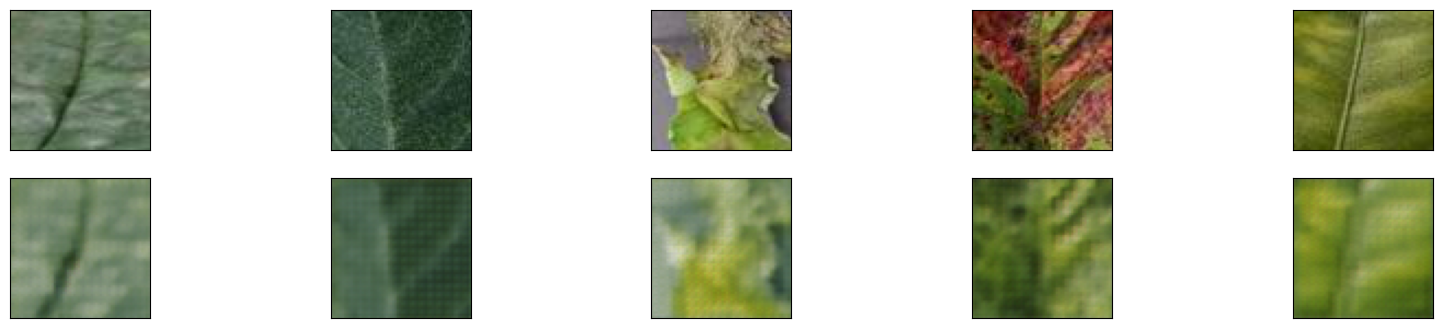

In [6]:
"""
-- Test image creation with autoencoder
"""

reconstructed_imgs = autoencoder.predict(X_test[:5])

n = 5  # número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
"""
Define encoder
"""
encoder = Model(input_img, latent)
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)
encoded_no_labels = encoder.predict(X_auto)

216/216 [==============================] - 1s 4ms/step


In [8]:
# Definir la arquitectura del clasificador utilizando el vector latente como entrada
input_latent = Input(shape=encoded_train[0].shape)
output = Flatten()(input_latent)
output = Dense(64, activation='relu')(output)
output = Dense(38, activation='sigmoid')(output)

# Crear el modelo del clasificador
classifier = Model(input_latent, output)

# Compilar el modelo del clasificador
optimizer = Adam(learning_rate = 0.0005)
classifier.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=700,
               batch_size=128,
               verbose=1,
               validation_data=(encoded_test, y_test))



Epoch 1/700
108/108 [==============================] - 6s 49ms/step - loss: 0.0440 - accuracy: 0.0469 - val_loss: 0.0255 - val_accuracy: 0.0902
Epoch 2/700
108/108 [==============================] - 5s 48ms/step - loss: 0.0253 - accuracy: 0.1008 - val_loss: 0.0251 - val_accuracy: 0.1153
Epoch 3/700
108/108 [==============================] - 5s 50ms/step - loss: 0.0249 - accuracy: 0.1264 - val_loss: 0.0248 - val_accuracy: 0.1387
Epoch 4/700
108/108 [==============================] - 5s 48ms/step - loss: 0.0246 - accuracy: 0.1481 - val_loss: 0.0245 - val_accuracy: 0.1611
Epoch 5/700
108/108 [==============================] - 5s 47ms/step - loss: 0.0244 - accuracy: 0.1707 - val_loss: 0.0244 - val_accuracy: 0.1669
Epoch 6/700
108/108 [==============================] - 5s 45ms/step - loss: 0.0242 - accuracy: 0.1872 - val_loss: 0.0242 - val_accuracy: 0.1968
Epoch 7/700
108/108 [==============================] - 5s 49ms/step - loss: 0.0239 - accuracy: 0.2104 - val_loss: 0.0240 - val_accuracy:

In [10]:
predictions = classifier.predict(encoded_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

432/432 [==============================] - 10s 24ms/step


In [11]:


# get the metrics
#print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

for i in range(38):
    test_label_mat.append([])
    predictions_mat.append([])
for i in range(len(real_values)):
    # y_test
    for j in range(38):
        test_label_mat[j].append(real_values[i] == j)  
        predictions_mat[j].append(predictions[i] == j)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)

Accuracy:  0.4014931864308495
Precision:  [0.1618705  0.25233645 0.09655172 0.47302905 0.4044665  0.25221239
 0.50742574 0.17575758 0.56392694 0.45260664 0.67173913 0.27015251
 0.47942387 0.51162791 0.35789474 0.58557047 0.52755906 0.47887324
 0.26100629 0.30882353 0.40992167 0.23636364 0.68953069 0.34868421
 0.48809524 0.32820513 0.42957746 0.26923077 0.49773756 0.14545455
 0.33156499 0.36231884 0.16616314 0.31914894 0.29608939 0.52757794
 0.20754717 0.48337029]
Recall:  [0.17857143 0.21774194 0.12727273 0.51818182 0.37045455 0.27078385
 0.5994152  0.14146341 0.56136364 0.48477157 0.70227273 0.28181818
 0.52954545 0.51162791 0.40236686 0.79318182 0.45681818 0.47222222
 0.20802005 0.33409091 0.3925     0.195      0.73180077 0.3557047
 0.65227273 0.43636364 0.41590909 0.23076923 0.5        0.12
 0.28409091 0.26246719 0.125      0.34090909 0.24090909 0.5
 0.14765101 0.49545455]
F1 score:  [0.16981132 0.23376623 0.10980392 0.49457701 0.38671412 0.26116838
 0.54959786 0.15675676 0.56264237

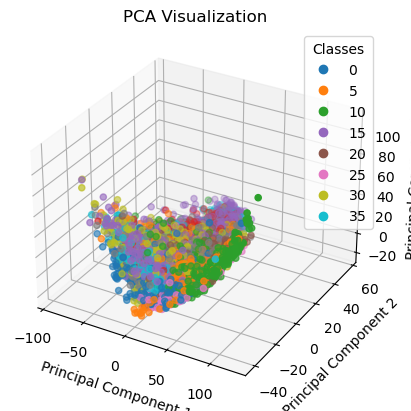

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(encoded_no_labels.reshape(6898,4096))

# Aplicar PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Guardar los resultados de PCA en TensorBoard
writer = SummaryWriter()
writer.add_embedding(X_pca, metadata=y_auto)
writer.close()
    
# Visualizar los resultados de PCA en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_auto, cmap='tab10')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.set_title('PCA Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()